In [25]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
from nltk.stem import PorterStemmer
import pandas as pd
import string
import re
from sklearn.feature_extraction.text import CountVectorizer
import timeit
import time
import matplotlib.pyplot as plt


In [10]:
def get_and_clean_data():
    data = pd.read_csv('../Resource/software_developer_united_states_1971_20191023_1.csv')
    description = data['job_description']
    cleaned_description = description.apply(lambda s: s.translate(str.maketrans('', '', string.punctuation + u'\xa0')))
    cleaned_description = cleaned_description.apply(lambda s: s.lower())
    cleaned_description = cleaned_description.apply(lambda s: s.translate(str.maketrans(string.whitespace, ' ' * len(string.whitespace), '')))
    cleaned_description = cleaned_description.drop_duplicates()
    return cleaned_description

In [37]:

def setup_exp( samples):
        cleaned_description = get_and_clean_data()[:samples]

        # replace non-alphabets with spaces, and collapse spaces
        cleaned_description = cleaned_description.apply(lambda s: re.sub(r'[^A-Za-z]', ' ', s))
        cleaned_description = cleaned_description.apply(lambda s: re.sub(r'\s+', ' ', s))

        # tokenize
        tokenized_description = cleaned_description.apply(lambda s: word_tokenize(s))

        # remove stop words
        stop_dict = set(stopwords.words())
        sw_removed_description = tokenized_description.apply(lambda s: set(s) - stop_dict)
       
        sw_removed_description = sw_removed_description.apply(lambda s: [word for word in s if len(word) > 2])

        # create stem caches
        concated = np.unique(np.concatenate([s for s in tokenized_description.values]))
        stem_cache = {}
        ps = PorterStemmer()
        for s in concated:
            stem_cache[s] = ps.stem(s)

        # stem
        stemmed_description = sw_removed_description.apply(lambda s: [stem_cache[w] for w in s])

        # print(tokenized_description)
        cv = CountVectorizer(analyzer=lambda x: x)
        vectorizer = cv.fit(stemmed_description)
        X = vectorizer.transform(stemmed_description)
        return X


In [ ]:

cleaned_description = get_and_clean_data()

# replace non alphabeths with spaces, and collapse spaces
cleaned_description = cleaned_description.apply(lambda s: re.sub(r'[^A-Za-z]', ' ', s))
cleaned_description = cleaned_description.apply(lambda s: re.sub(r'\s+', ' ', s))

# tokenize
tokenized_description = cleaned_description.apply(lambda s: word_tokenize(s))

# remove stop words
stop_dict = set(stopwords.words())
sw_removed_description = tokenized_description.apply(lambda s: set(s) - stop_dict)
# sw_removed_description = tokenized_description.apply(lambda s: list(OrderedSet(s) - stop_dict))
sw_removed_description = sw_removed_description.apply(lambda s: [word for word in s if len(word) > 2])


# create stem caches
concated = np.unique(np.concatenate([s for s in tokenized_description.values]))
stem_cache = {}
ps = PorterStemmer()
for s in concated:
    stem_cache[s] = ps.stem(s)

# stem
stemmed_description = sw_removed_description.apply(lambda s: [stem_cache[w] for w in s])

# print(tokenized_description)


cv = CountVectorizer(analyzer=lambda x: x)
vectorizer = cv.fit(stemmed_description)
X = vectorizer.transform(stemmed_description)

XX = X.toarray()
print(np.shape(np.matmul(X.toarray(), X.toarray().T)))



In [38]:
w_values = list(range(1000, 10001, 9000))

arr = {}
dok = {}
lil = {}
coo = {}
csc = {}

# Loop over the values of w
for w in w_values:
    print(w)
    X = setup_exp(w)
    
    arr[w] = timeit.timeit(lambda: np.matmul(X.toarray(), X.toarray().T), number=1)
    dok[w] = timeit.timeit(lambda: X.todok() * X.T.todok(), number=1)
    lil[w] = timeit.timeit(lambda: X.tolil() * X.T.tolil(), number=1)
    coo[w] = timeit.timeit(lambda: X.tocoo() * X.T.tocoo(), number=1)
    csc[w] = timeit.timeit(lambda: X.tocsc() * X.T.tocsc(), number=1)

# Print the results
print("Array Multiplication:", arr)
print("Dok Multiplication:", dok)
print("Lil Multiplication:", lil)
print("Coo Multiplication:", coo)
print("Csc Multiplication:", csc)

1000
10000
Array Multiplication: {1000: 9.329847469001834, 10000: 1749.8958218180014}
Dok Multiplication: {1000: 0.31004090500209713, 10000: 8.145241595000698}
Lil Multiplication: {1000: 0.11042681699836976, 10000: 6.209698593997018}
Coo Multiplication: {1000: 0.08168586399915512, 10000: 5.774078408998321}
Csc Multiplication: {1000: 0.07202050200066878, 10000: 5.725970400999358}


In [3]:
results = {'Array': arr, 'Dok': dok, 'Lil': lil, 'Coo': coo, 'Csc': csc}
df = pd.DataFrame(results)
print(df)


NameError: name 'arr' is not defined

In [2]:
# Plotting
plt.figure(figsize=(10, 6))
for method in df.columns:
    plt.plot(df.index, df[method], marker='o', label=method)

plt.xlabel('Number of Samples (w)')
plt.ylabel('Time (s)')
plt.title('Sparse Matrix Multiplication Timings')
plt.legend(title='Multiplication Method')
plt.grid(True)
plt.show()

NameError: name 'plt' is not defined

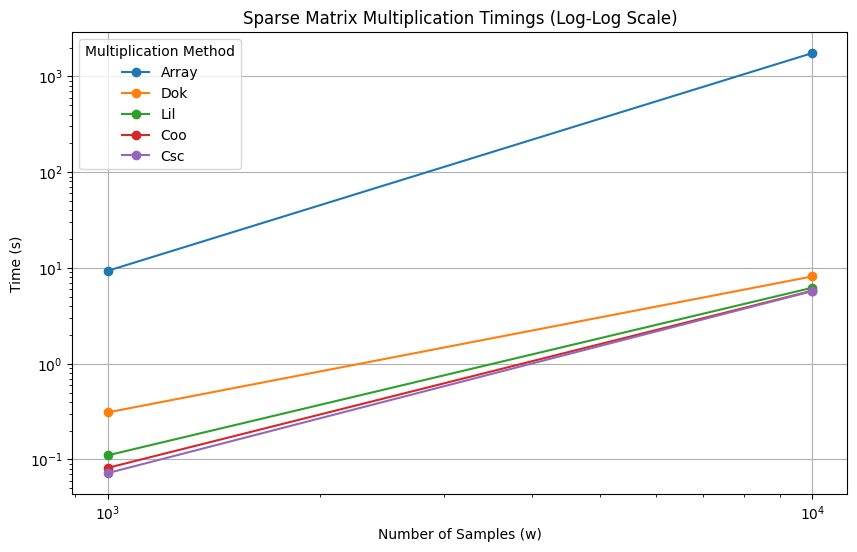

In [54]:
# Plotting in log-log scale
plt.figure(figsize=(10, 6))
for method in df.columns:
    plt.loglog(df.index, df[method], marker='o', label=method)

plt.xlabel('Number of Samples (w)')
plt.ylabel('Time (s)')
plt.title('Sparse Matrix Multiplication Timings (Log-Log Scale)')
plt.legend(title='Multiplication Method')
plt.grid(True)
plt.show()